## Importing modules and defining functions

In [1]:
#Import modules
from matplotlib import pylab as plt
from tqdm import tqdm
import itertools

import pickle
import numpy as np
from sklearn import linear_model
import skcosmo.feature_selection
from skcosmo.sample_selection import FPS, PCovFPS
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time

from rascal.models import KRR
from rascal.utils import dump_obj, load_obj

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj
from rascal.utils import get_score
from rascal.utils.io import load_json, dump_json


In [2]:
#Define functions
def do_fps(x, d=0):
    """
    Function for performing farthest-point-sampling for a given feature matrix.
    d gives the number of farthest-point-sampled feature vectors that will be outputted. 
    If d==0, the entire set will be FPS-sorted.
    Returns the FPS-sorted IDs, as well as the FPS distances.
    """
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = 0
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    dss = []
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
        dss.append(max(dl))
    return iy,dss

def get_forces(frames):
    frc = np.zeros((np.sum([len(frm) for frm in frames]),3))
    iat = 0
    for ifrm,frm in enumerate(frames):
        frc[iat:iat+len(frm)] = frm.get_array('forces') 
        iat += len(frm)
    return frc

#Get feature vectors for a list of atoms objects. This requires soap to be set, as well as all_species, which is
#a list with one atoms object that contains all species HCNO
def get_features(atoms_objects, batch_size=1000, progress_bar=True):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        This requires soap to be set.
    '''
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        if got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in tqdm(range(int(len(atoms_objects)/batch_size+0.9999)), leave=False,
                  disable = not progress_bar): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

In [4]:
#Import initial combined dataset (geop+100MD per crystal)
dictionary_file = open("raw_data/CSD-10k_combined_w_kpts.pickle", "rb") #open saved pickle database
db = pickle.load(dictionary_file)
names=list(db.keys())

# FPS-Sort Configurations

In [3]:
#Define soap hyperparameters for FPS sorting configurations
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4, #cutoff distance in angstroms
              max_radial=6, #no. of radial basis functions
              max_angular=4, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=2
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False #don't care about forces right now
              )
soap = SphericalInvariants(**hypers)


In [55]:
#FPS-sort initial training set to get 11 configurations per crystal
db_FPS = {}
selector = FPS(n_to_select=11, initialize=0) #initialize at 0 so that first selection is always geop

for name in tqdm(names):
    all_feats = []
    for ifrm, frm in enumerate(db[name]):
        frm.wrap(eps=1e-13)
        feats = soap.transform(frm).get_features(soap)
        all_feats.append(np.mean(feats, axis=0))
    selector.fit(all_feats)
    frames = []
    for i in selector.selected_idx_:
        frames.append(db[name][i])
    db_FPS[name] = frames

  0%|          | 0/2238 [00:00<?, ?it/s]

In [66]:
#Save dataset
with open('delta_data/CSD-10k_combined_w_kpts_11_pc.pickle', 'wb') as f:
    pickle.dump(db_FPS, f)

# Calculate DFTB Energies and Forces

Note that these calculations were done locally on CosmoPC12, and they will not run automatically here. That is because I had to change some ASE scripts as it was not producing DFTB+ input files correctly for the parameters I had provided.

I thoroughly checked the input files it produced, and it matches the input files that were used to run DFTB+ with the Delta potential of Aditi/Edgar in the past.

Also **important to note** that the "Temperatute" passed through to the DFTB+ input file had to be converted from Kelvin to Hartree (DFTB+'s internal parameters), as it was very difficult to set "Temperature [K]" instead of just "Temperature" through ASE's python interface.

Please **skip the next few cells below**, and just reload the database that contains the DFTB+ results as well. 

In [ ]:
#Load database
with open('delta_data/CSD-10k_combined_w_kpts_11_pc.pickle', 'rb') as f:
    db = pickle.load(f)

In [4]:
#get array of all crystal names
names = []
for key in db.keys():
    names.append(key)

In [ ]:
#set preliminary DFTB params
#These should be the exact same as I have found in DFTB input scripts from Edgar/Aditi (I thoroughly checked)
calc_preliminary = Dftb(Hamiltonian_='DFTB',
           Hamiltonian_Charge=0,
           Hamiltonian_DampXH='Yes',
           Hamiltonian_DampXHExponent = 4.0,
           Hamiltonian_Dispersion_ = 'DftD3',
           Hamiltonian_Dispersion_Damping='BeckeJohnson{}',
           Hamiltonian_Eigensolver='RelativelyRobust{}',
           Hamiltonian_HubbardDerivs_='',
           Hamiltonian_MaxAngularMomentum_='',
           Hamiltonian_SCC='Yes',
           Hamiltonian_SCCTolerance=1e-4,
           Hamiltonian_MaxSCCIterations=1000,
           Hamiltonian_SlaterKosterFiles_='Type2FileNames',
           Hamiltonian_SlaterKosterFiles_Prefix='"./dftb-param/"',
           Hamiltonian_SlaterKosterFiles_Separator='"-"',
           Hamiltonian_SlaterKosterFiles_Suffix='".skf"',
           Hamiltonian_SlaterKosterFiles_LowerCaseTypeName='No',
           Hamiltonian_ThirdOrderFull='Yes',
           Hamiltonian_Filling_='Fermi',
           Hamiltonian_Filling_Temperature=300*0.316681534524639E-05, #convert from K to Hartree!
           #Options_WriteResultsTag='No',
           #Options_WriteDetailedOut='No',
           #Options_WriteBandOut='No',
           ParserOptions_='',
           ParserOptions_ParserVersion=4,
           ParserOptions_IgnoreUnprocessedNodes = 'No',
           do_mulliken=False)

In [ ]:
#Data that will need to be set in the loop, depending on which species are present

#Hamiltonian_HubbardDerivs_H=-0.1857, 
#Hamiltonian_HubbardDerivs_C=-0.1492, 
#Hamiltonian_HubbardDerivs_N=-0.1535, 
#Hamiltonian_HubbardDerivs_O=-0.1575,
#Hamiltonian_MaxAngularMomentum_H='"s"', 
#Hamiltonian_MaxAngularMomentum_C='"p"', 
#Hamiltonian_MaxAngularMomentum_N='"p"', 
#Hamiltonian_MaxAngularMomentum_O='"p"',

In [ ]:
#Rename "forces" array to "PBE-D2_forces" to avoid confusion, and rename "energy" to "PBE-D2_energy"
for name in names:
    for frm in db[name]:
        frm.arrays['PBE-D2_forces'] = frm.arrays['forces'].copy() #add new array with good name
        frm.set_array('forces', None) #remove old array
        frm.info['PBE-D2_energy'] = frm.info['energy'].copy() #add new info with energy
        frm.info.pop('energy') #remove old energy info

In [ ]:
#Compute DFTB energies and forces, and add them to the frames
for name in tqdm(names, desc="Crystal Progress", leave=False):
    for frm in tqdm(db[name], desc="Config Progress", leave=False):
        
        kpts = np.array2string(frm.info['kpts'], separator=' ')[1:-1] #Get K-points
        if len(kpts) != 5: #Print k points if they are longer than useful (for security) 
            print(name, frm) 
        kpts += ' 1.0' #add the k points "weight" for DFTB+
        
        calc=Dftb(**calc_preliminary.todict()) #Get preliminary calculator
        calc.set(Hamiltonian_KPointsAndWeights="{"+kpts+"}") #Set k points
        
        #Set Hubbard derivs and max angular momenta for the relevant species present
        if "H" in frm.get_chemical_symbols():
            calc.set(Hamiltonian_HubbardDerivs_H=-0.1857)
            calc.set(Hamiltonian_MaxAngularMomentum_H='"s"')
        if "C" in frm.get_chemical_symbols():
            calc.set(Hamiltonian_HubbardDerivs_C=-0.1492)
            calc.set(Hamiltonian_MaxAngularMomentum_C='"p"')
        if "N" in frm.get_chemical_symbols():
            calc.set(Hamiltonian_HubbardDerivs_N=-0.1535)
            calc.set(Hamiltonian_MaxAngularMomentum_N='"p"')
        if "O" in frm.get_chemical_symbols():
            calc.set(Hamiltonian_HubbardDerivs_O=-0.1575)
            calc.set(Hamiltonian_MaxAngularMomentum_O='"p"')
        
        frm.set_calculator(calc) #set calculator for the frame
        
        frm.info['DFTB_energy'] = frm.get_potential_energy() #calculate potential energy, and add it as info
        frm.arrays['DFTB_forces'] = frm.get_forces() #calculate forces, and add them as info

In [ ]:
#Save dataset
with open('delta_data/CSD-10k_combined_w_kpts_11_pc_w_DFTB.pickle', 'wb') as f:
    pickle.dump(db, f)

## Reload database with DFTB+ results

In [4]:
#(Re-)Open dataset
with open('delta_data/CSD-10k_combined_w_kpts_11_pc_w_DFTB.pickle', 'rb') as f:
    db = pickle.load(f)

In [5]:
#Add energy and force deltas to frame
for name in db.keys():
    for frm in db[name]:
        frm.info['Delta_energy'] = frm.info['PBE-D2_energy'] - frm.info['DFTB_energy']
        frm.arrays['Delta_forces'] = frm.arrays['PBE-D2_forces'] - frm.arrays['DFTB_forces']

# Create training and validation sets

In [6]:
#Create training and val sets
all_frames = []
for name in db.keys():
    for frm in db[name]:
        all_frames.append(frm)

ids = np.arange(len(all_frames))
np.random.seed(10)
np.random.shuffle(ids)

train_frames = [all_frames[i] for i in ids[1000:]]
val_frames = [all_frames[i] for i in ids[:1000]]

In [7]:
#Create composition (X), energy deltas (y) and force deltas (f) arrays
X_all = np.zeros((len(all_frames), 4), dtype=int) ; y_all = np.zeros(len(all_frames), dtype=float)
f_all = np.zeros((np.sum([len(frm) for frm in all_frames]),3), dtype=float)

counter = 0
for ifrm, frm in enumerate(all_frames):
    symbols = frm.get_atomic_numbers()
    X_all[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    y_all[ifrm] = frm.info['Delta_energy']
    f_all[counter:counter+len(frm)] = frm.arrays['Delta_forces']
    counter += len(frm)
    
X_train = np.zeros((len(train_frames), 4), dtype=int) ; y_train = np.zeros(len(train_frames), dtype=float)
f_train = np.zeros((np.sum([len(frm) for frm in train_frames]),3), dtype=float)

counter = 0
for ifrm, frm in enumerate(train_frames):
    symbols = frm.get_atomic_numbers()
    X_train[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    y_train[ifrm] = frm.info['Delta_energy']
    f_train[counter:counter+len(frm)] = frm.arrays['Delta_forces']
    counter += len(frm)

X_val = np.zeros((len(val_frames), 4), dtype=int) ; y_val = np.zeros(len(val_frames), dtype=float)
f_val = np.zeros((np.sum([len(frm) for frm in val_frames]),3), dtype=float)

counter = 0
for ifrm, frm in enumerate(val_frames):
    symbols = frm.get_atomic_numbers()
    X_val[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    y_val[ifrm] = frm.info['Delta_energy']
    f_val[counter:counter+len(frm)] = frm.arrays['Delta_forces']
    counter += len(frm)

In [8]:
#Create baselined per-atom energy model
mlr = Ridge(fit_intercept=False, alpha=1e-4)
mlr.fit(X_all, y_all)
for spec, coef in zip(['H', 'C', 'N', 'O'], mlr.coef_):
    print(f"Per-atom energy for species {spec} : {coef} eV")

Per-atom energy for species H : -5.937468668126814 eV
Per-atom energy for species C : -108.2661438737962 eV
Per-atom energy for species N : -318.9167048223052 eV
Per-atom energy for species O : -476.5706321823649 eV


In [9]:
#Save small model
with open('delta_data/mlr.pkl','wb') as f:
    pickle.dump(mlr, f)

# PCovFPS sample selection

In [25]:
#Create baselined per-atom binding energies of training and validation sets
yred_train = y_train/np.sum(X_train,axis=1)-mlr.predict(X_train)/np.sum(X_train,axis=1)
yred_val = y_val/np.sum(X_val,axis=1)-mlr.predict(X_val)/np.sum(X_val,axis=1) 

In [26]:
#Use better hypers
hypers['interaction_cutoff'] = 6
hypers['max_radial'] = 9
hypers['max_angular'] = 6
soap=SphericalInvariants(**hypers)

In [27]:
#get per-structure training features
train_feats = get_features(train_frames, batch_size=250, progress_bar=True)

  0%|          | 0/95 [00:00<?, ?it/s]

In [28]:
#Do PCovFPS Sample selection
selector = PCovFPS(mixing=0.5, initialize=0, progress_bar=True, n_to_select=len(train_feats)-1)
selector.fit(train_feats, yred_train)
pcf_ids = selector.selected_idx_

  0%|          | 0/23616 [00:00<?, ?it/s]

In [29]:
#Save PCovFPS-sorted sample IDs
np.save('delta_data/pcovfps_selected_idx', pcf_ids)

In [30]:
#Reload PCovFPS-sorted sample IDs
pcf_ids = np.load('delta_data/pcovfps_selected_idx.npy')

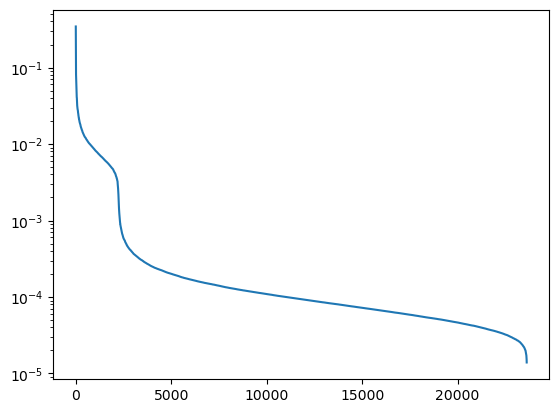

In [31]:
#Plot distances
plt.plot(range(len(train_feats)-2), selector.get_select_distance()[1:])
plt.yscale('log')

PCovFPS suggests maybe using 6000 or so structures is not an awful idea, in order to balance computational burden with accuracy.

# Small Hyperparam Optimisation

In [14]:
#Small loop for SOAP hypers optimisation
for rc in [4,6,8]:
    for n in [6,9,12]:
        for l in [4,6,8]:
            hypers['interaction_cutoff'] = rc
            hypers['max_radial'] = n
            hypers['max_angular'] = l
            soap=SphericalInvariants(**hypers)
            
            feats_t = get_features(train_frames[:10000], batch_size=250)
            feats_v = get_features(val_frames, batch_size=250)
            
            model = Ridge(fit_intercept=False, alpha=1e-4)
            model.fit(feats_t, y_small[:3750])
            
            predictions = model.predict(feats_v)
            errors = predictions - y_small[3750:]
            rmse = np.sqrt(np.mean(np.abs(errors)))
            
            print(f"RMSE using rc={rc}, n={n}, l={l} : {np.round(rmse, 6)} eV")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=6, l=4 : 1.043688 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=6, l=6 : 1.025771 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=6, l=8 : 1.014872 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=9, l=4 : 1.042269 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=9, l=6 : 1.018662 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=9, l=8 : 1.009446 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=12, l=4 : 1.037987 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=12, l=6 : 1.014619 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=12, l=8 : 1.003798 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=6, l=4 : 1.023154 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=6, l=6 : 1.011613 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=6, l=8 : 0.995652 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=9, l=4 : 1.012423 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=9, l=6 : 1.000087 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=9, l=8 : 0.985657 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=12, l=4 : 1.007791 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=12, l=6 : 0.994335 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=12, l=8 : 0.978967 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=6, l=4 : 1.065337 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=6, l=6 : 1.048606 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=6, l=8 : 1.032453 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=9, l=4 : 1.013074 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=9, l=6 : 0.991521 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=9, l=8 : 0.96705 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=12, l=4 : 0.993759 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=12, l=6 : 0.977424 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=12, l=8 : 0.961028 eV


In [33]:
#Loop for soap hyperparameter optimisation
n_train = 10000

results=[]
count=0; 
#Iterate over interaction cuttoff

for rc in [4.,6.,8.]:
    hypers['interaction_cutoff']=rc
    
    #Iterate over scale
    for n in [6,9,12]:
        hypers['max_radial'] = n
        
        #Iterate over exponent
        for l in [4,6,8]:
            start = time()
            hypers['max_angular'] = l
            soap = SphericalInvariants(**hypers) #redefine soap with new parameters
            #print("Iteration: ", count+1, "/ 36") #keep count of iteration
            train_feat=get_features(train_frames[:n_train], batch_size=250) #get features for training set
            val_feat=get_features(val_frames, batch_size=250) #get features for validation set
            count+=1
            
            #Normalise feature vectors
            for feat in train_feat:
                feat/=np.linalg.norm(feat)
            for feat in val_feat:
                feat/=np.linalg.norm(feat)

            #Iterate over zeta values
            for zeta in [2.,3.]:
                K = np.dot(train_feat,train_feat.T)**zeta #compute covariance matrix for training
                Kval = np.dot(val_feat,train_feat.T)**zeta #compute covariance matrix for validation

                #Iterate over regularization values
                minerr = 1e24 ; minreg = 0
                for reg in np.logspace(-9,-5,5):
                    KRR = KernelRidge(kernel='precomputed',alpha = reg)
                    KRR.fit(K,yred_train[:n_train])
                    err = np.std(yred_val - KRR.predict(Kval))
                    if err < minerr:
                        minerr = err.copy()
                        minreg = reg.copy()
                results.append([minerr, rc, n, l, zeta, minreg])
            print(f"Results using rc={rc}, n={n}, l={l}, zeta={zeta}, minreg={minreg}:")
            print(f"Error = {minerr} eV/atom")
            print('Time taken: ',time()-start)
            print("---------------------------------------------------------------------------------")

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=4, zeta=3.0, minreg=1e-05:
Error = 0.003336002785217394 eV/atom
Time taken:  81.88889241218567
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=6, zeta=3.0, minreg=1e-05:
Error = 0.003309462061763038 eV/atom
Time taken:  99.24900221824646
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=8, zeta=3.0, minreg=1e-05:
Error = 0.0032783918274639783 eV/atom
Time taken:  121.45538020133972
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=4, zeta=3.0, minreg=1e-05:
Error = 0.0032924446824565655 eV/atom
Time taken:  105.38145017623901
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=6, zeta=3.0, minreg=1e-05:
Error = 0.0032649808755064024 eV/atom
Time taken:  143.81601977348328
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=8, zeta=3.0, minreg=1e-05:
Error = 0.0032512236768953103 eV/atom
Time taken:  184.834636926651
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=12, l=4, zeta=3.0, minreg=1e-05:
Error = 0.0032930356919597618 eV/atom
Time taken:  145.25313425064087
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=12, l=6, zeta=3.0, minreg=1e-05:
Error = 0.0032722603862221813 eV/atom
Time taken:  198.4149661064148
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=12, l=8, zeta=3.0, minreg=1e-05:
Error = 0.0032584151023967835 eV/atom
Time taken:  260.11613631248474
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=4, zeta=3.0, minreg=1e-05:
Error = 0.0032617533834723555 eV/atom
Time taken:  134.26059556007385
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=6, zeta=3.0, minreg=1e-05:
Error = 0.003215413070008251 eV/atom
Time taken:  174.0540931224823
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=8, zeta=3.0, minreg=1e-05:
Error = 0.003210622761523323 eV/atom
Time taken:  223.2677764892578
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=9, l=4, zeta=3.0, minreg=1e-05:
Error = 0.003140881433231713 eV/atom
Time taken:  165.3098120689392
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=9, l=6, zeta=3.0, minreg=1e-05:
Error = 0.003066097290216129 eV/atom
Time taken:  234.3080632686615
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=9, l=8, zeta=3.0, minreg=1e-05:
Error = 0.003024141312240806 eV/atom
Time taken:  316.5952978134155
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=12, l=4, zeta=3.0, minreg=1e-05:
Error = 0.003171357614468681 eV/atom
Time taken:  209.14312887191772
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=12, l=6, zeta=3.0, minreg=1e-05:
Error = 0.003110579247998621 eV/atom
Time taken:  303.42199516296387
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=12, l=8, zeta=3.0, minreg=1e-05:
Error = 0.0030911986715829935 eV/atom
Time taken:  417.37284874916077
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=6, l=4, zeta=3.0, minreg=1e-05:
Error = 0.003399377945394419 eV/atom
Time taken:  237.00242948532104
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=6, l=6, zeta=3.0, minreg=1e-05:
Error = 0.0033572883659647762 eV/atom
Time taken:  318.25767993927
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=6, l=8, zeta=3.0, minreg=1e-05:
Error = 0.0033466552653936645 eV/atom
Time taken:  419.1527421474457
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=9, l=4, zeta=3.0, minreg=1e-05:
Error = 0.003151610598964201 eV/atom
Time taken:  279.24709582328796
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=9, l=6, zeta=3.0, minreg=1e-05:
Error = 0.003099843288946592 eV/atom
Time taken:  407.04337430000305
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=9, l=8, zeta=3.0, minreg=1e-05:
Error = 0.003078392411355435 eV/atom
Time taken:  572.6248948574066
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=12, l=4, zeta=3.0, minreg=1e-05:
Error = 0.0031401645944787475 eV/atom
Time taken:  332.01562762260437
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=12, l=6, zeta=3.0, minreg=1e-05:
Error = 0.003049739647829518 eV/atom
Time taken:  504.2500720024109
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=12, l=8, zeta=3.0, minreg=1e-05:
Error = 0.0030186421370690794 eV/atom
Time taken:  719.6348259449005
---------------------------------------------------------------------------------


In [34]:
np.save('delta_data/hyperparam_optimisation_results', np.asarray(results))

hyperopt=np.load('delta_data/hyperparam_optimisation_results.npy')

# Find optimal hyperparameters, which correspond to the lowest error
hyperopt[np.where(hyperopt==np.amin(hyperopt, axis=0)[0])[0]]

array([[3.01864214e-03, 8.00000000e+00, 1.20000000e+01, 8.00000000e+00,
        3.00000000e+00, 1.00000000e-05]])

In [37]:
#Loop for soap hyperparameter optimisation
n_train = 10000

results_gauss=[]
count=0; 
#Iterate over interaction cuttoff

for rc in [4.,6.]:
    hypers['interaction_cutoff']=rc
    
    #Iterate over scale
    for n in [6,9]:
        hypers['max_radial'] = n
        
        #Iterate over exponent
        for l in [4,6]:
            hypers['max_angular'] = l
            
            for gauss in [0.2, 0.3, 0.4, 0.5]:
                hypers['gaussian_sigma_constant'] = gauss
                start = time()
                soap = SphericalInvariants(**hypers) #redefine soap with new parameters
                #print("Iteration: ", count+1, "/ 36") #keep count of iteration
                train_feat=get_features(train_frames[:n_train], batch_size=250) #get features for training set
                val_feat=get_features(val_frames, batch_size=250) #get features for validation set
                count+=1

                #Normalise feature vectors
                for feat in train_feat:
                    feat/=np.linalg.norm(feat)
                for feat in val_feat:
                    feat/=np.linalg.norm(feat)

                #Iterate over zeta values
                for zeta in [2.,3.]:
                    K = np.dot(train_feat,train_feat.T)**zeta #compute covariance matrix for training
                    Kval = np.dot(val_feat,train_feat.T)**zeta #compute covariance matrix for validation

                    #Iterate over regularization values
                    minerr = 1e24 ; minreg = 0
                    for reg in np.logspace(-9,-5,5):
                        KRR = KernelRidge(kernel='precomputed',alpha = reg)
                        KRR.fit(K,yred_train[:n_train])
                        err = np.std(yred_val - KRR.predict(Kval))
                        if err < minerr:
                            minerr = err.copy()
                            minreg = reg.copy()
                    results_gauss.append([minerr, rc, n, l, gauss, zeta, minreg])
                    print(f"Results using rc={rc}, n={n}, l={l}, gauss={gauss}, zeta={zeta}, minreg={minreg}:")
                    print(f"Error = {minerr} eV/atom")
                    print('Time taken: ',time()-start)
                    print("---------------------------------------------------------------------------------")

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=4, gauss=0.2, zeta=2.0, minreg=1e-06:
Error = 0.003728977991732251 eV/atom
Time taken:  63.87083435058594
---------------------------------------------------------------------------------
Results using rc=4.0, n=6, l=4, gauss=0.2, zeta=3.0, minreg=1e-06:
Error = 0.003576528211944912 eV/atom
Time taken:  80.55424070358276
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=4, gauss=0.3, zeta=2.0, minreg=1e-06:
Error = 0.0036166181474782256 eV/atom
Time taken:  63.87961030006409
---------------------------------------------------------------------------------
Results using rc=4.0, n=6, l=4, gauss=0.3, zeta=3.0, minreg=1e-05:
Error = 0.0033889698697007952 eV/atom
Time taken:  80.61461138725281
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=4, gauss=0.4, zeta=2.0, minreg=1e-05:
Error = 0.003549099407193268 eV/atom
Time taken:  64.32818365097046
---------------------------------------------------------------------------------
Results using rc=4.0, n=6, l=4, gauss=0.4, zeta=3.0, minreg=1e-05:
Error = 0.003336002784868447 eV/atom
Time taken:  82.16261625289917
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=4, gauss=0.5, zeta=2.0, minreg=1e-05:
Error = 0.0037128894050290806 eV/atom
Time taken:  64.00150656700134
---------------------------------------------------------------------------------
Results using rc=4.0, n=6, l=4, gauss=0.5, zeta=3.0, minreg=1e-05:
Error = 0.0034275626045648694 eV/atom
Time taken:  80.72156190872192
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=6, gauss=0.2, zeta=2.0, minreg=1e-06:
Error = 0.0036976709914159508 eV/atom
Time taken:  83.58781313896179
---------------------------------------------------------------------------------
Results using rc=4.0, n=6, l=6, gauss=0.2, zeta=3.0, minreg=1e-05:
Error = 0.0035725852951190617 eV/atom
Time taken:  100.76356601715088
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=6, gauss=0.4, zeta=2.0, minreg=1e-05:
Error = 0.0034846661942808145 eV/atom
Time taken:  84.05329918861389
---------------------------------------------------------------------------------
Results using rc=4.0, n=6, l=6, gauss=0.4, zeta=3.0, minreg=1e-05:
Error = 0.003309462061908323 eV/atom
Time taken:  101.18383646011353
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=6, gauss=0.5, zeta=2.0, minreg=1e-05:
Error = 0.003658610418059853 eV/atom
Time taken:  83.60352778434753
---------------------------------------------------------------------------------
Results using rc=4.0, n=6, l=6, gauss=0.5, zeta=3.0, minreg=1e-05:
Error = 0.003412604069560694 eV/atom
Time taken:  100.80333542823792
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=4, gauss=0.2, zeta=2.0, minreg=1e-06:
Error = 0.003815873052860442 eV/atom
Time taken:  87.32802510261536
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=4, gauss=0.2, zeta=3.0, minreg=1e-05:
Error = 0.0035562213182211526 eV/atom
Time taken:  105.26402187347412
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=4, gauss=0.3, zeta=2.0, minreg=1e-05:
Error = 0.003535903802687005 eV/atom
Time taken:  87.23755931854248
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=4, gauss=0.3, zeta=3.0, minreg=1e-05:
Error = 0.0033029906099550366 eV/atom
Time taken:  105.12631726264954
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=4, gauss=0.4, zeta=2.0, minreg=1e-05:
Error = 0.0034650605592127636 eV/atom
Time taken:  86.97673606872559
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=4, gauss=0.4, zeta=3.0, minreg=1e-05:
Error = 0.003292444682437117 eV/atom
Time taken:  104.92616653442383
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=4, gauss=0.5, zeta=2.0, minreg=1e-05:
Error = 0.00364215864163527 eV/atom
Time taken:  87.0994029045105
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=4, gauss=0.5, zeta=3.0, minreg=1e-05:
Error = 0.003403551188596302 eV/atom
Time taken:  105.03994250297546
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=6, gauss=0.2, zeta=2.0, minreg=1e-06:
Error = 0.0037678140116025076 eV/atom
Time taken:  125.46758389472961
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=6, gauss=0.2, zeta=3.0, minreg=1e-05:
Error = 0.003499873693294303 eV/atom
Time taken:  144.21193408966064
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=6, gauss=0.3, zeta=2.0, minreg=1e-05:
Error = 0.0034573842947204936 eV/atom
Time taken:  125.05274844169617
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=6, gauss=0.3, zeta=3.0, minreg=1e-05:
Error = 0.0032609378688749843 eV/atom
Time taken:  143.77879929542542
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=6, gauss=0.4, zeta=2.0, minreg=1e-05:
Error = 0.0033996236782084187 eV/atom
Time taken:  125.60542297363281
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=6, gauss=0.4, zeta=3.0, minreg=1e-05:
Error = 0.0032649808757396577 eV/atom
Time taken:  144.4166488647461
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=6, gauss=0.5, zeta=2.0, minreg=1e-05:
Error = 0.003580896273935685 eV/atom
Time taken:  124.93761348724365
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=6, gauss=0.5, zeta=3.0, minreg=1e-05:
Error = 0.0033832598177934107 eV/atom
Time taken:  143.74483132362366
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=4, gauss=0.2, zeta=2.0, minreg=1e-06:
Error = 0.0034574663414286807 eV/atom
Time taken:  116.72413444519043
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=4, gauss=0.2, zeta=3.0, minreg=1e-05:
Error = 0.0032649672184883595 eV/atom
Time taken:  133.46645092964172
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=4, gauss=0.3, zeta=2.0, minreg=1e-05:
Error = 0.003406373233342118 eV/atom
Time taken:  117.00523805618286
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=4, gauss=0.3, zeta=3.0, minreg=1e-05:
Error = 0.003227737847416436 eV/atom
Time taken:  133.80000710487366
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=4, gauss=0.4, zeta=2.0, minreg=1e-05:
Error = 0.0034372034556241684 eV/atom
Time taken:  117.32609033584595
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=4, gauss=0.4, zeta=3.0, minreg=1e-05:
Error = 0.0032617533833880453 eV/atom
Time taken:  134.08903741836548
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=4, gauss=0.5, zeta=2.0, minreg=1e-06:
Error = 0.0035585300086519653 eV/atom
Time taken:  117.02691316604614
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=4, gauss=0.5, zeta=3.0, minreg=1e-05:
Error = 0.003352396382342394 eV/atom
Time taken:  133.7808394432068
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=6, gauss=0.2, zeta=2.0, minreg=1e-05:
Error = 0.00340793370117842 eV/atom
Time taken:  158.044917345047
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=6, gauss=0.2, zeta=3.0, minreg=1e-05:
Error = 0.003263660118312655 eV/atom
Time taken:  175.13648104667664
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=6, gauss=0.3, zeta=2.0, minreg=1e-05:
Error = 0.003341927045182621 eV/atom
Time taken:  158.81839752197266
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=6, gauss=0.3, zeta=3.0, minreg=1e-05:
Error = 0.003197866449004104 eV/atom
Time taken:  175.93037915229797
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=6, gauss=0.4, zeta=2.0, minreg=1e-05:
Error = 0.003392474210433983 eV/atom
Time taken:  159.90526819229126
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=6, gauss=0.4, zeta=3.0, minreg=1e-05:
Error = 0.0032154130695879932 eV/atom
Time taken:  177.08552813529968
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=6, gauss=0.5, zeta=2.0, minreg=1e-05:
Error = 0.003540718200147211 eV/atom
Time taken:  158.31112790107727
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=6, gauss=0.5, zeta=3.0, minreg=1e-05:
Error = 0.0033165529925520834 eV/atom
Time taken:  175.49212217330933
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=9, l=4, gauss=0.2, zeta=2.0, minreg=1e-06:
Error = 0.0034316815827771076 eV/atom
Time taken:  147.99601340293884
---------------------------------------------------------------------------------
Results using rc=6.0, n=9, l=4, gauss=0.2, zeta=3.0, minreg=1e-05:
Error = 0.0032509224111980026 eV/atom
Time taken:  165.97528624534607
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=9, l=4, gauss=0.3, zeta=2.0, minreg=1e-05:
Error = 0.0032436129398091436 eV/atom
Time taken:  147.89372992515564
---------------------------------------------------------------------------------
Results using rc=6.0, n=9, l=4, gauss=0.3, zeta=3.0, minreg=1e-05:
Error = 0.0031333298430689343 eV/atom
Time taken:  165.89367079734802
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=9, l=4, gauss=0.4, zeta=2.0, minreg=1e-05:
Error = 0.003250605467293558 eV/atom
Time taken:  151.63241481781006
---------------------------------------------------------------------------------
Results using rc=6.0, n=9, l=4, gauss=0.4, zeta=3.0, minreg=1e-05:
Error = 0.0031408814332406394 eV/atom
Time taken:  169.55414390563965
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [40]:
np.save('delta_data/hyperparam_optimisation_results_gauss', np.asarray(results_gauss))

hyperopt=np.load('delta_data/hyperparam_optimisation_results_gauss.npy')

# Find optimal hyperparameters, which correspond to the lowest error
hyperopt[np.where(hyperopt==np.amin(hyperopt, axis=0)[0])[0]]

array([[3.06609729e-03, 6.00000000e+00, 9.00000000e+00, 6.00000000e+00,
        4.00000000e-01, 3.00000000e+00, 1.00000000e-05]])